In [13]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib as mpl

from IPython.display import display

import matplotlib.pylab as pylab

from matplotlib import rc

import torch
from torch.nn.functional import log_softmax
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_style('whitegrid')

ood_transforms = ['brightness', 'defocus_blur', 'fog',
                  'glass_blur', 'jpeg_compression',
                  'motion_blur', 'shot_noise', 'zoom_blur', 'contrast',
                  'elastic_transform', 'frost', 'gaussian_noise', 'impulse_noise',
                  'pixelate', 'snow',
#                   'speckle_noise', 'spatter', 'gaussian_blur', 'saturate'
                  ]
names = {'CIFAR100':{
    'VGG16BN': {
        'cropflip': 'CIFAR100-VGG16BN-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR100-VGG16BN-100-randaugment_N3_M30.npy',
        'policy':  'CIFAR100-VGG16BN-100-gpspolicy.npy',
        'notta': 'CIFAR100-VGG16BN-1-no_tta.npy'
    },
    'PreResNet110':{
        'cropflip': 'CIFAR100-PreResNet110-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR100-PreResNet110-100-randaugment_N3_M0_false_m0.npy',
        'policy':  'CIFAR100-PreResNet110-100-gpspolicy.npy',
        'notta': 'CIFAR100-PreResNet110-1-no_tta.npy'
    },
        'WideResNet28x10':{
        'cropflip': 'CIFAR100-WideResNet28x10-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR100-WideResNet28x10-100-randaugment_N3_M35.npy',
        'policy':  'CIFAR100-WideResNet28x10-100-gpspolicy.npy',
        'notta': 'CIFAR100-WideResNet28x10-1-no_tta.npy'
    }
},
        'CIFAR10':{
    'VGG16BN': {
        'cropflip': 'CIFAR10-VGG16BN-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR10-VGG16BN-100-randaugment_N3_M0_false_m0.npy',
        'policy':  'CIFAR10-VGG16BN-100-gpspolicy_newpolicy.npy',
        'notta': 'CIFAR10-VGG16BN-1-no_tta.npy'
    },
    'PreResNet110':{
        'cropflip': 'CIFAR10-PreResNet110-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR10-PreResNet110-100-randaugment_N3_M0_false_m0.npy',
        'policy':  'CIFAR10-PreResNet110-100-gpspolicy.npy',
        'notta': 'CIFAR10-PreResNet110-1-no_tta.npy'
    },         
    'WideResNet28x10':{
        'cropflip': 'CIFAR10-WideResNet28x10-100-randaugment_N3_M0.npy',
        'rand_optimalm': 'CIFAR10-WideResNet28x10-100-randaugment_N3_M0_false_m0.npy',
        'policy':  'CIFAR10-WideResNet28x10-100-gpspolicy.npy',
        'notta': 'CIFAR10-WideResNet28x10-1-no_tta.npy'
    }               
            }}
short_legend_augs = {'cropflip': 'CF',
                     'rand_optimalm': 'M*',
                     'policy': 'GPS',
                     'notta': 'CC'}
model_names = {'VGG16BN': 'VGG',
              'PreResNet110': 'ResNet110',
              'WideResNet28x10': 'WideResNet'
             }
colors_augs = {'cropflip': 0,
             'rand_optimalm': 1,
             'policy': 2,
             'notta': 3}
colors_palette = [
    '#bcbd22', '#e377c2', '#9467bd',
    '#8c564b', '#1f77b4', '#d62728',
    '#2ca02c', '#ff7f0e', '#7f7f7f']
dataset_names = {'CIFAR10': 'CIFAR-10',
                'CIFAR100': 'CIFAR-100'}

matplotlib.rcParams['text.usetex'] = True

In [14]:
def get_base(classes):
    cropflip = np.load('ood_res_cifar/CIFAR' + str(classes) + '-VGG16BN-100-randaugment_N3_M0.npy', allow_pickle=True).item()
    base = defaultdict()
    for transform in ood_transforms:
        er = 0.
        for severity in range(5):
            acc = cropflip['ens_acc'][transform][str(severity)][str(5)][0]
            er += (1. - acc) / 5
        base[transform] = er
    return base
base = {'CIFAR100': get_base(100), 'CIFAR10': get_base(10)}

In [15]:
metric = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
metric_severity = defaultdict(lambda: defaultdict(lambda:
                                                  defaultdict(lambda: defaultdict(lambda:
                                                                                  defaultdict(list)))))
for dataset in names.keys():
    for model in names[dataset].keys():
        for aug in names[dataset][model].keys():
            local_metrics = np.load('ood_res_cifar/' + names[dataset][model][aug], allow_pickle=True).item()
            for i in range(100):
                aggr_er = 0.
                for transform in ood_transforms:
                    error = 0.
                    for severity in range(5):
                        num_ens = i
                        if aug == 'notta':
                            num_ens = 0
                        loc_er = 1. - local_metrics['ens_acc'][transform][str(severity)][str(num_ens)][0]
                        error += loc_er / 5
                        metric_severity[dataset][model][aug][transform][str(severity)].append(loc_er)
                    aggr_er += error / len(ood_transforms)
                metric[dataset][model][aug].append(aggr_er)

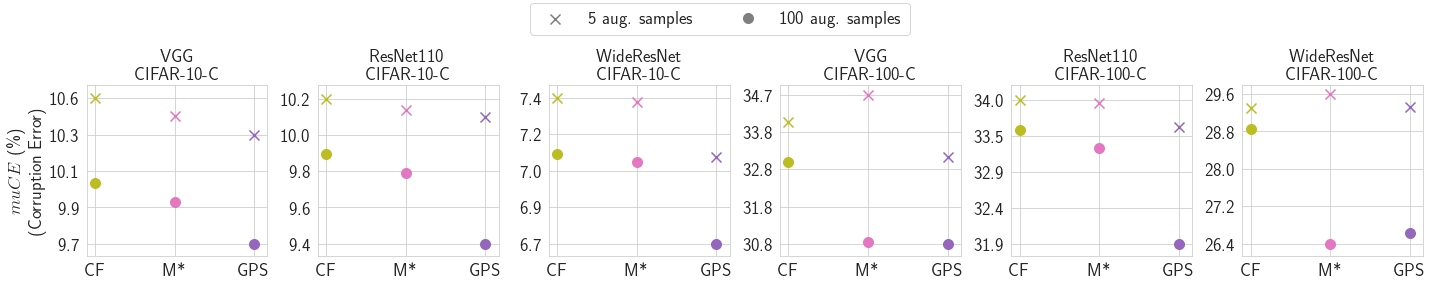

In [16]:
params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'lines.markersize': 10,
         'legend.markerscale': 1.,
         'legend.labelspacing': 1.,
         'figure.subplot.hspace': 0.3,
         'figure.subplot.wspace': 0.05,
         }
pylab.rcParams.update(params)
models = [ 'VGG16BN', 'PreResNet110', 'WideResNet28x10',]
augs = [ 'notta', 'cropflip', 'rand_optimalm','policy',][1:]
sample_nums = [5, 100]
datasets = ['CIFAR10', 'CIFAR100']
nan = np.nan
f = plt.figure(figsize=(20, 3.5))
i = 1
short_legend_augs_ordered = []
for aug in augs:
    short_legend_augs_ordered.append(short_legend_augs[aug])

for dataset in datasets:
    for model in models:
        plt.subplot(1, len(datasets)*len(models), i)
        min_ = +100500
        max_ = -100500
        i += 1
        lines = []
        for j, aug in enumerate(augs):
            plot_augs = []
            legends = []
            for sample_num in sample_nums:
                marker = 'o'
                if sample_num < 100:
                    marker = 'x'
                if aug == 'notta':
                    marker = (5, 1)
                if aug != 'notta' or sample_num == 100:
                    lines.append(plt.plot([j], [100*metric[dataset][model][aug][sample_num - 1]], marker=marker,
                             linewidth=0, c=colors_palette[colors_augs[aug]], alpha=0)[0])
                    legends.append(plt.scatter([j], [100*metric[dataset][model][aug][sample_num - 1]], marker=marker,
                                c=colors_palette[colors_augs[aug]]))
                    val = 100*metric[dataset][model][aug][sample_num - 1]
                    min_ = min(min_, val)
                    max_ = max(max_, val)
            plt.title(model_names[model] + '\n' + dataset_names[dataset] + '-C')
            plt.xticks(np.arange(len(augs)), short_legend_augs_ordered)
            plt.yticks(np.linspace(min_, max_, 5))
            from matplotlib.ticker import FormatStrFormatter
            plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            if i == 2:
                plt.ylabel(r'$muCE$ (\%)''\n''(Corruption Error)')
cross = plt.scatter([np.nan], [np.nan], color=colors_palette[-1], marker='x',
                          label='5 aug. samples')
circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                          label='100 aug. samples')
star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
                          label='1 aug. sample')
f.legend(handles=[cross, circle], loc='upper center', ncol=3,
        bbox_to_anchor=(0.5, 1.16))
plt.tight_layout()
plt.savefig('figs/ood_cifar.pdf', bbox_inches="tight")

In [17]:
res_for_table = []
models = [ 'VGG16BN', 'PreResNet110', 'WideResNet28x10',]
augs = [ 'notta', 'cropflip', 'rand_optimalm','policy',]
sample_nums = [5, 10, 100]# np.arange(99) + 1
datasets = ['CIFAR10', 'CIFAR100']
augs_to_table = {'notta': 'Clean',
                 'cropflip': 'CF',
                 'rand_optimalm': 'Mgrid',
                 'policy': 'GPS'}

for dataset in datasets:
    for model in models:
        for j, aug in enumerate(augs):
            for sample_num in sample_nums:
                res_for_table.append([dataset, model_names[model], augs_to_table[aug], sample_num, 'muCE', '',
                                     round(100*metric[dataset][model][aug][sample_num - 1], 4), 0., 0.])

In [18]:
res_for_table

[['CIFAR10', 'VGG', 'Clean', 5, 'muCE', '', 11.6515, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'Clean', 10, 'muCE', '', 11.6515, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'Clean', 100, 'muCE', '', 11.6515, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'CF', 5, 'muCE', '', 10.5587, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'CF', 10, 'muCE', '', 10.3132, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'CF', 100, 'muCE', '', 10.0676, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'Mgrid', 5, 'muCE', '', 10.4575, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'Mgrid', 10, 'muCE', '', 10.1881, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'Mgrid', 100, 'muCE', '', 9.9555, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'GPS', 5, 'muCE', '', 10.3436, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'GPS', 10, 'muCE', '', 10.0096, 0.0, 0.0],
 ['CIFAR10', 'VGG', 'GPS', 100, 'muCE', '', 9.7156, 0.0, 0.0],
 ['CIFAR10', 'ResNet110', 'Clean', 5, 'muCE', '', 10.9296, 0.0, 0.0],
 ['CIFAR10', 'ResNet110', 'Clean', 10, 'muCE', '', 10.9296, 0.0, 0.0],
 ['CIFAR10', 'ResNet110', 'Clean', 100, 'muCE', '', 10.9296, 0.0, 0.0],
 ['CIFAR10', 'ResNet110'